In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import copy as cp
import glob
%matplotlib inline

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    """ class Line:  """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the line
        self.recent_xfitted = []
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        #x values for detected line pixels
        self.allx = None
        
        #y values for detected line pixels
        self.ally = None

## Step 1: Camera Calibration

In [4]:
# chessboard size is different in this one
nx, ny = 9, 6

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#images = [ 'camera_cal/calibration2.jpg' ]

# Step through the list and search for chessboard corners
foundCount = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)

    if ret == True:
        foundCount += 1
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

print ('Found chessboard in %d out of %d images' % (foundCount, len(images)))

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
cameraCaleb = {
    'ret' : ret
    , 'mtx' : mtx
    , 'dist': dist
    , 'rvecs' : rvecs
    , 'tvecs' : tvecs
}

print ("Saving results to `cameraCaleb.pickle`")
with open('cameraCaleb.pickle', 'wb') as f:
    pickle.dump(cameraCaleb, f)


Found chessboard in 17 out of 20 images
Saving results to `cameraCaleb.pickle`


### Load Pickled Camera Calibration Info

In [5]:
with open('cameraCaleb.pickle', 'rb') as f:
    cameraCaleb = pickle.load(f)

## Step 2: Distortion Correction

In [6]:
def undistort_img(img):
    return cv2.undistort(img, cameraCaleb['mtx'], cameraCaleb['dist'], None, cameraCaleb['mtx'])

In [7]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def transform(img):
    # Get the dimensions
    width, height = img.shape[1], img.shape[0]
    img_size = (width, height)

    #src = np.float32( [[200, 720], [1100, 720], [595, 450], [685, 450]])

    #dst = np.float32( [[300, 720], [980, 720], [300, 0], [980, 0]])
    
    # define the trapezoid
    src = np.float32([[605, 445], [685, 445],
                      [1063, 676], [260, 676]])
    dst = np.float32([[width * 0.35, 0], [width * 0.65, 0], 
                      [width * 0.65, height], [ width * 0.35, height]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(img, M, (int(width), int(height)), flags=cv2.INTER_LINEAR), M, Minv


TypeError: Image data cannot be converted to float

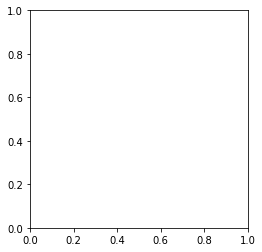

In [8]:
# Let's make sure we know what we're doing here.
img1 = mpimg.imread('test_images/straight_lines1.jpg')
fimg = transform(undistort_img(img1))
plt.imshow(fimg)


## Step 3: Color/gradient threshold

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Return the direction of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def hls_thresh(img, thresh=(100, 255)):
	"""
	Convert RGB to HLS and threshold to binary image using S channel
	"""
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]
	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
	return binary_output


def combined_thresh(img):
	abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
	mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
	dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
	hls_bin = hls_thresh(img, thresh=(170, 255))

	combined = np.zeros_like(dir_bin)
	combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

	return combined #, abs_bin, mag_bin, dir_bin, hls_bin  # DEBUG

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [11]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sxbinary = abs_sobel_thresh(l_channel, orient='x', thresh_min=20, thresh_max=100)
    sybinary = abs_sobel_thresh(l_channel, orient='y', thresh_min=20, thresh_max=100)
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    combined = np.zeros_like(s_binary)
    combined[(sxbinary == 1) | (s_binary == 1)] = 1
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    return combined
    

## Step 6: Determine the lane curvature

In [12]:
def fitPolyLanes(binary_warped):
    """ fitPolyLanes - fit a polynomial curve """
    binary_warped = binary_warped.astype(np.uint8)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    print (binary_warped.shape)
    print ( 'max', np.amax(binary_warped))
    print ( 'min', np.amin(binary_warped))
    print ('width', binary_warped.shape[0])
    print ('height', binary_warped.shape[1])
    
    # shape[0] is Y, hence this does histogram of the bottom half
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    #histogram = np.sum(binary_warped, axis=0)
    
    #plt.plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    #o = np.zeros_like(binary_warped, np.uint8)
    #out_img = np.dstack((o,o,o)) * 255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
    print ('histogram', histogram.shape)
    midpoint = np.int(histogram.shape[0] / 2)
    minpoint = np.int(histogram.shape[0] * 0.25)
    maxpoint = np.int(histogram.shape[0] * 0.80)
    
    print ('midpoint', midpoint)
    print ('minpoint', minpoint)
    print ('maxpoint', maxpoint)
    
    leftx_base = np.argmax(histogram[minpoint:midpoint]) + minpoint
    rightx_base = np.argmax(histogram[midpoint:maxpoint]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 50
    
    # Set minimum number of pixels found to recenter window
    minpix = 15
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 5) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, histogram, out_img

In [13]:

def runWindows(leftx_base, rightx_base, warped, doingUp=True, margin=50, minpix=50):
    ''' 
    - margin - set the width of the windows +/- margin
    - minpix - set the minimum of pixels found to recenter window
    - 
    
    '''
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    left_boxes = []
    right_boxes = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        left_boxes.append (((win_xleft_low, win_y_low), (win_xleft_high, win_y_high)))
        right_boxes.append (((win_xright_low, win_y_low), (win_xright_high, win_y_high)))
                
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    result = {
          'left_lane_inds' : left_lane_inds
        , 'right_lane_inds' : right_lane_inds
        , 'left_boxes' : left_boxes
        , 'right_boxes' : right_boxes
    }
    
    return result


def bigPolyFit (binary_warped):
    ''' '''
    
    # First step is to locate the centers to the left and right of center
    
    
    # Get the boxes starting from the top and bottom
    left_res = runWindows(leftx_base, rightx_base, warped, doingUp=True)
    right_res = runWindows(leftx_base, rightx_base, warped, doingUp=False)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
def fitPolyLanesNew(binary_warped):
    """ fitPolyLanes - fit a polynomial curve """
    binary_warped = binary_warped.astype(np.uint8)
    
    # shape[0] is Y, hence this does histogram of the bottom half
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    #histogram = np.sum(binary_warped, axis=0)
    
    #plt.plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    #o = np.zeros_like(binary_warped, np.uint8)
    #out_img = np.dstack((o,o,o)) * 255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
    print ('histogram', histogram.shape)
    midpoint = np.int(histogram.shape[0] / 2)
    minpoint = np.int(histogram.shape[0] * 0.25)
    maxpoint = np.int(histogram.shape[0] * 0.80)
    
    print ('midpoint', midpoint)
    print ('minpoint', minpoint)
    print ('maxpoint', maxpoint)
    
    leftx_base = np.argmax(histogram[minpoint:midpoint]) + minpoint
    rightx_base = np.argmax(histogram[midpoint:maxpoint]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 50
    
    # Set minimum number of pixels found to recenter window
    minpix = 15
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 5) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, histogram, out_img

In [14]:
def visualisePolyFit (img, leftLaneFit, rightLaneFit, leftLaneInds, rightLaneInds):
    """ visualisePolyFit """
    
    # Generate x and y values for plotting
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Calculate the actual fitted plots
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = leftLaneFit[0] * ploty**2 + leftLaneFit[1] * ploty + leftLaneFit[2]
    right_fitx = rightLaneFit[0] * ploty**2 + rightLaneFit[1] * ploty + rightLaneFit[2]
    
    # 
    out_img = np.dstack((img, img, img))*255
    out_img[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
    out_img[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
    plt.imshow(out_img)
    
    # Plot the actual lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [15]:
def overlayGreenZone(undist, warped, leftLaneFit, rightLaneFit):
    """ Overlay a green zone on the original image """
    
    # Get the x,y of the fitted lines
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = leftLaneFit[0]*ploty**2 + leftLaneFit[1]*ploty + leftLaneFit[2]
    right_fitx = rightLaneFit[0]*ploty**2 + rightLaneFit[1]*ploty + rightLaneFit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image (img):
    """ """
    undist = undistort_img(img)

    # color and gradient
    #gray_bin = pipeline(undist)
    gray_bin = combined_thresh(undist)

    # transform
    warped, M, Minv = transform(gray_bin)

    # fit lanes (left & right)
    leftLane, rightLane, leftLaneInds, rightLaneInds, histogram, out_img = fitPolyLanes(warped)
    #cv2.imwrite('hello.jpg',out_img)

    # draw lane fits
    #drawn = visualisePolyFit(warped, leftLane, rightLane, leftLaneInds, rightLaneInds)

    # draw the green zone for the car
    return overlayGreenZone (undist, warped, leftLane, rightLane)
    

## Single image pipeline

In [18]:
img = mpimg.imread('test_images/frame.png')
# undistort it
undist = undistort_img(img)

# color and gradient
gray_bin = pipeline(img)
gray_bin = gray_bin.astype(np.uint8)
#gray_bin = combined_thresh(undist)

plt.imshow(gray_bin)

# transform
warped, M, Minv = transform(gray_bin)

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/frame.png'

(720, 1280)
max 1
min 0
width 720
height 1280
histogram (1280,)
midpoint 640
minpoint 320
maxpoint 1024


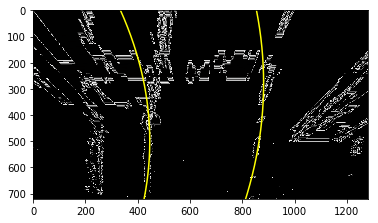

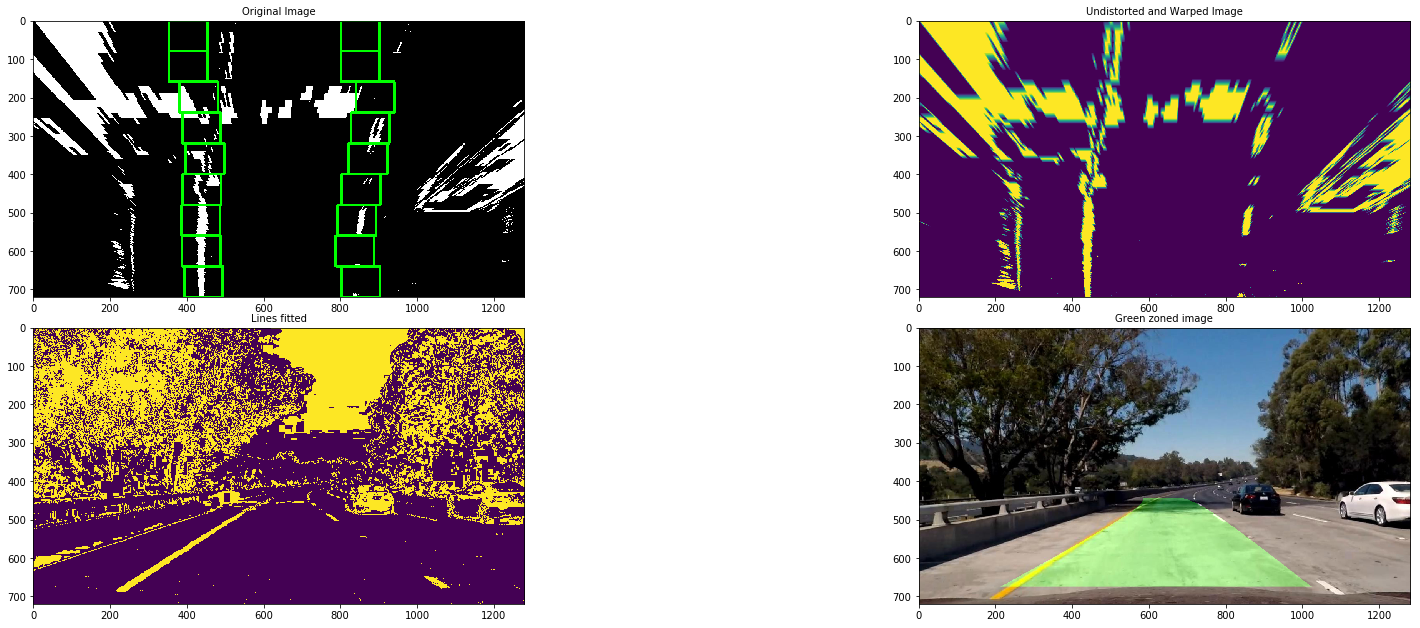

In [19]:
img = mpimg.imread('test_images/frame.jpg')
# undistort it

undist = undistort_img(img)

# color and gradient
gray_bin = pipeline(img)
#gray_bin = combined_thresh(undist)

plt.imshow(gray_bin)

# transform
warped, M, Minv = transform(gray_bin)

# fit lanes (left & right)
leftLane, rightLane, leftLaneInds, rightLaneInds, histogram, out_img = fitPolyLanes(warped)

# draw lane fits
visualisePolyFit(warped, leftLane, rightLane, leftLaneInds, rightLaneInds)

# draw the green zone for the car
img_zone = overlayGreenZone (undist, warped, leftLane, rightLane)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=10)
ax3.imshow(gray_bin)
ax3.set_title('Lines fitted', fontsize=10)
ax4.imshow(img_zone)
ax4.set_title('Green zoned image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.imshow(img_zone)


### Project video

In [ ]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("input_videos/project_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Harder video

In [30]:
white_output = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("input_videos/challenge_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

(720, 1280)


TypeError: expected non-empty vector for x

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Harder challenger video

In [292]:
white_output = 'output_videos/harder_challenge_video.mp4'
clip1 = VideoFileClip("input_videos/harder_challenge_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

(720, 1280)
max 1
min 0
width 720
height 1280
histogram (1280,)
midpoint 640
minpoint 320
maxpoint 1024
[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

(720, 1280)
max 1
min 0
width 720
height 1280
histogram (1280,)
midpoint 640
minpoint 320
maxpoint 1024


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file output_videos/harder_challenge_video.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))